In [1]:
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
# creating of encoder 

codings_size = 100
EPSILON = 0.00005
dropout_p = 0.4

encoder_input = keras.Input(shape = [128, 128, 3])

x = keras.layers.Conv2D(64, kernel_size=[5,5], strides=[2,2], padding="SAME")(encoder_input)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(128, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(256, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(512, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(1024, kernel_size=[5,5], strides=[1,1], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Reshape((8*8*1024,))(x)
x = keras.layers.Dense(codings_size, activation=None)(x)
encoder_output = keras.layers.LeakyReLU(0.2)(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [5]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512 

In [6]:
# creating of decoder

decoder_input = keras.Input(shape = [codings_size])
x = keras.layers.Dense(8*8*1024, activation=None)(decoder_input)
x = keras.layers.Reshape((8,8,1024))(x)
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(1024, kernel_size=[5,5], strides=[1,1], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(512, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(3, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x  = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
decoder_output= keras.activations.sigmoid(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 1024)        26215424  
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 1024)        0   

In [8]:
# combine encoder and decoder to autoencoder
autoencoder = keras.models.Sequential([encoder, decoder])

In [9]:
# detemine the total number of images

from keras.preprocessing.image import ImageDataGenerator
from glob import glob

data_path = '/kaggle/input/celebrities-100k/100k/100k'

filenames = np.array(glob(os.path.join(data_path, '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 100000


In [25]:
# creating 'data flow' from data directory using ImageDataGenerator class

BATCH_SIZE = 512

data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(directory = '/kaggle/input/celebrities-100k/100k/', 
                                               classes=['100k'], target_size = (128,128),
                                               color_mode="rgb",batch_size = BATCH_SIZE,
                                               class_mode="input",shuffle = True,seed=42)

Found 100000 images belonging to 1 classes.


In [11]:
# create loss and accuracy functions

def r_loss(y_true, y_pred):
    return keras.backend.mean(keras.backend.square(y_true - y_pred), axis = [1,2,3])

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

#from keras.callbacks import ModelCheckpoint
#checkpoint_ae = ModelCheckpoint(os.path.join('/kaggle/working/', 'checkpoints/weights.h5'), 
                                #save_weights_only = True, verbose=1, save_best_only=True, 
                                #monitor='rounded_accuracy', mode='max')

In [66]:
# compile the model

tf.random.set_seed(42)
np.random.seed(42)

LEARNING_RATE = 0.0005

optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)

autoencoder.compile(optimizer=optimizer, loss = r_loss, metrics=[rounded_accuracy])

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [67]:
# later, the model was trained during 30 epochs with 'Adam' optimazer with lr = 0.001 and 'r_loss' loss function
# autoencoder.load_weights('/kaggle/working/weights.h5')

In [68]:
# training

N_EPOCHS = 10

history = autoencoder.fit(data_flow, shuffle=True, epochs = N_EPOCHS, steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/10
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Execu

In [77]:
#autoencoder.save('/kaggle/working/weights.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


In [28]:
# take one batch of data
batch_example = next(data_flow)[0]

In [30]:
# select one image from the batch
img_example = tf.expand_dims(batch_example[14], 0).numpy()
rec_img_example = autoencoder(img_example).numpy()

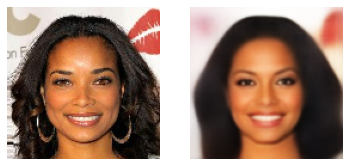

In [69]:
# plot the original and reconstructed images

def plot_one_image(image):
    image = np.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis("off")
    
def plot_image_pair(original_image, reconstructed_image):
    original_image = np.squeeze(original_image, axis=0)
    reconstructed_image = np.squeeze(reconstructed_image, axis=0)
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)    
    plt.axis("off")
        
plot_image_pair(img_example, rec_img_example)   

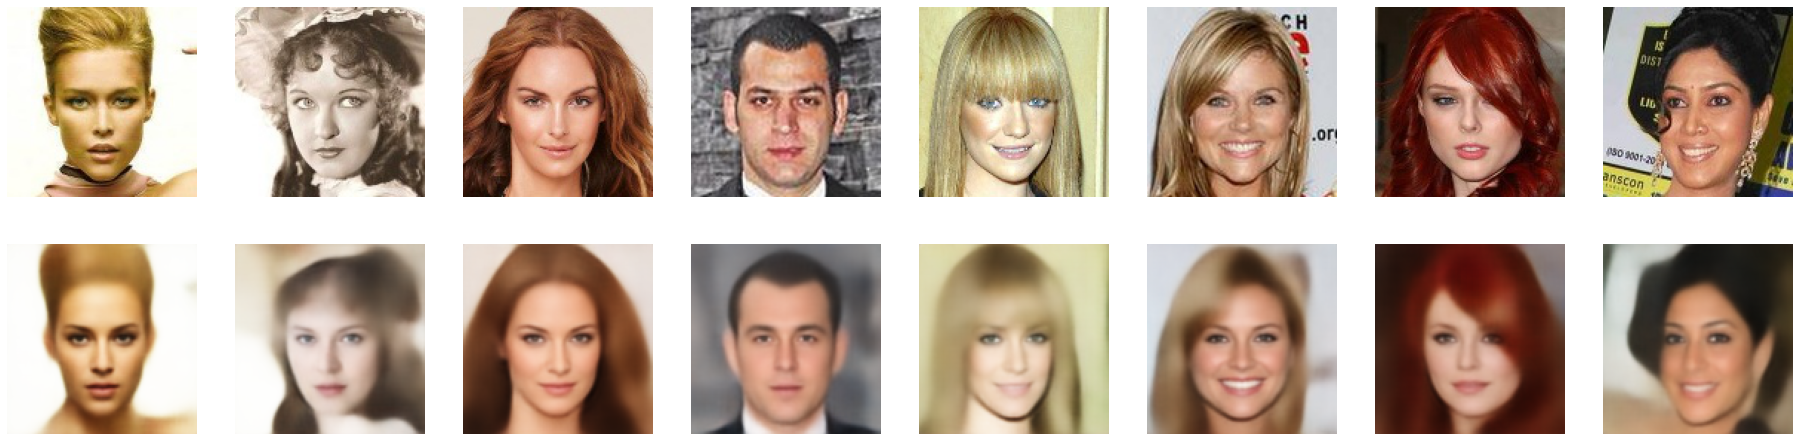

In [76]:
# plot several original and reconstructed images

def plot_multiple_images(images_batch, n = 8, n_init = 0, model = autoencoder):
    n_cols = n
    n_rows = 2
    plt.figure(figsize=(4*n_cols, 4*n_rows))
    for i in range(n):
        index = i + n_init
        image = tf.expand_dims(images_batch[index], 0).numpy()
        rec_image = model(image).numpy()
        image = np.squeeze(image, axis=0)
        rec_image = np.squeeze(rec_image, axis=0)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(n_rows, n_cols, i + 1 + n)
        plt.imshow(rec_image)
        plt.axis("off")
    
plot_multiple_images(batch_example, n = 8, n_init = 200)

# The first row shows images directly from the dataset and 
# the second row shows images that have been passed through the autoencoder